In [2]:
import numpy as np

from models import *
from gen_model import GPT

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
joint_dims = 66
seq_len = 50
target_offset = 25
step_size = 1
hidden_size = 64
batch_size = 16

is_cuda = torch.cuda.is_available()
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

GT_model = GPT(n_layer=6, n_head=6, n_embd=192, vocab_size=joint_dims*2, block_size=seq_len*2-1, pdrop=0.1, device=device)
GT_model.load_state_dict(torch.load('trained_model_data/GT_iso1_small_statedict.pt'))
GT_model.eval()

number of parameters: 2.71M


GPT(
  (transformer): ModuleDict(
    (wte): Linear(in_features=132, out_features=192, bias=True)
    (wpe): Embedding(99, 192)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=192, out_features=576, bias=True)
          (c_proj): Linear(in_features=192, out_features=192, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=192, out_features=768, bias=True)
          (c_proj): Linear(in_features=768, out_features=192, bias=True)
          (act): NewGELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((192,), eps=1e-05, elementwise_affine=True)


In [4]:
GT_model

for name, param in GT_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

transformer.wte.weight tensor([[-0.0768, -0.0367, -0.0130,  ...,  0.1306, -0.0809, -0.0481],
        [ 0.0542,  0.0606, -0.0088,  ..., -0.0894, -0.2567,  0.0155],
        [ 0.1061, -0.0117,  0.0526,  ..., -0.3321,  0.0639,  0.0412],
        ...,
        [ 0.0713, -0.0485,  0.0101,  ..., -0.0233, -0.2557, -0.0186],
        [-0.0536,  0.0759,  0.0669,  ...,  0.1233,  0.2486,  0.0528],
        [ 0.1657, -0.0750, -0.0236,  ..., -0.1222, -0.2889,  0.0731]],
       device='cuda:0')
transformer.wte.bias tensor([ 0.0029, -0.0086,  0.0137, -0.0009, -0.0247, -0.0069,  0.0076,  0.0130,
         0.0309, -0.0131,  0.0217, -0.0075, -0.0011,  0.0236,  0.0019,  0.0205,
        -0.0180,  0.0460,  0.0110, -0.0396,  0.0096,  0.0054,  0.0069, -0.0024,
        -0.0123,  0.0268, -0.0171, -0.0298, -0.0218,  0.0159,  0.0070,  0.0027,
        -0.0250, -0.0211,  0.0097, -0.0444,  0.0185, -0.0237,  0.0048,  0.0057,
        -0.0008,  0.0009,  0.0192,  0.0073,  0.0039,  0.0019,  0.0008, -0.0009,
         0.0163,  

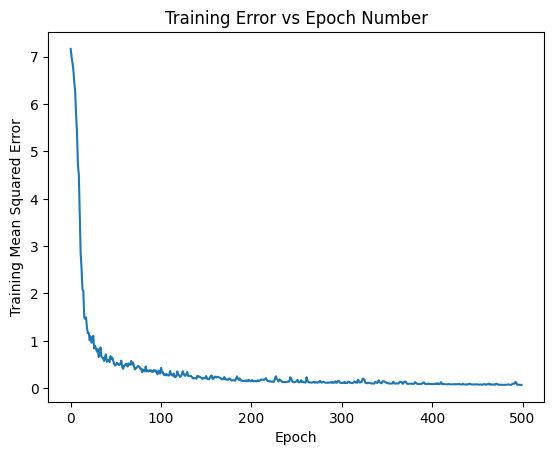

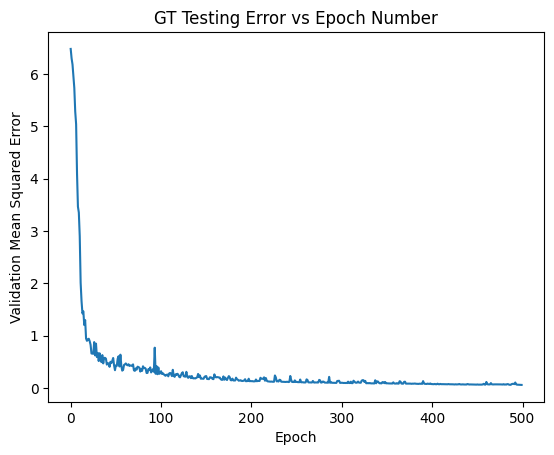

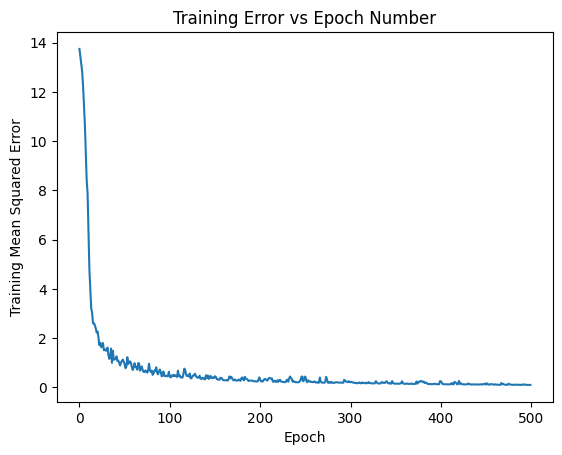

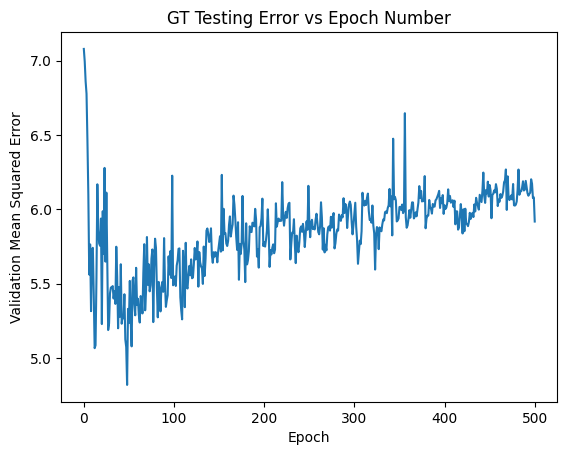

In [5]:
epoch_losses_gt1 = np.loadtxt('trained_model_data/epoch_losses_GT_2.gz')
evaluations_gt1 = np.loadtxt('trained_model_data/evaluations_GT_2.gz')

plt.plot(epoch_losses_gt1)
plt.title("Training Error vs Epoch Number")
plt.xlabel("Epoch")
plt.ylabel("Training Mean Squared Error")
plt.show()

plt.plot(evaluations_gt1)
plt.title("GT Testing Error vs Epoch Number")
plt.xlabel("Epoch")
plt.ylabel("Validation Mean Squared Error")
plt.show()


epoch_losses_gt_iso = np.loadtxt('trained_model_data/epoch_losses_GT_iso1_direct.gz')
evaluations_gt_iso = np.loadtxt('trained_model_data/evaluations_GT_iso1_direct.gz')

plt.plot(epoch_losses_gt_iso)
plt.title("Training Error vs Epoch Number")
plt.xlabel("Epoch")
plt.ylabel("Training Mean Squared Error")
plt.show()

plt.plot(evaluations_gt_iso)
plt.title("GT Testing Error vs Epoch Number")
plt.xlabel("Epoch")
plt.ylabel("Validation Mean Squared Error")
plt.show()


In [4]:
from train_utils import evaluate_masks, evaluate_stupid, evaluate_standard
from torch.utils.data import DataLoader
from individual_TF import IndividualTF
import time

data_subsets = torch.utils.data.random_split(dataset, [100, 200, 400, 800, 1600, 3200, len(dataset)-6300])
data_loaders = [DataLoader(data_subset, batch_size=64, num_workers=0, shuffle=True) for data_subset in data_subsets]

criterion = F.mse_loss

# model1 = torch.load('trained_model_data/TransformerModel5.pt', map_location="cpu")
model2 = torch.load('trained_model_data/EncoderDecoderModel.pt', map_location=torch.device('cpu'))
model3 = torch.load('trained_model_data/GRU.pt', map_location=torch.device('cpu'))

# joint_dims = 66
# model = IndividualTF(enc_inp_size=joint_dims*2, dec_inp_size=(joint_dims*2)+(joint_dims//3), dec_out_size=joint_dims*2, device=device)
# model.load_state_dict(model1.state_dict())

# for parameter in model1.parameters():
#     parameter = parameter.to(torch.device('cpu'))
#     # print(parameter.to(torch.device('cpu')))
    
# print(model.cuda())


eval1 = []
eval2 = []
eval3 = []

time1 = []
time2 = []
time3 = []
for data_loader in data_loaders[:-1]:
    # start = time.process_time()
    # e1 = evaluate_masks(model1, data_loader, criterion, torch.device('cpu'))
    # end = time.process_time()
    # time1.append(end-start)
    # eval1.append(e1)

    start = time.process_time()
    e2 = evaluate_stupid(model2, data_loader, criterion, torch.device('cpu'))
    end = time.process_time()
    time2.append(end-start)
    eval2.append(e2)

    start = time.process_time()
    e3 = evaluate_standard(model3, data_loader, criterion, torch.device('cpu'))
    end = time.process_time()
    time3.append(end-start)
    eval3.append(e3)

print(time1)
print(time2)
print(time3)

print(eval1)
print(eval2)
print(eval3)



[]
[2.111623999999999, 3.360427999999999, 6.7980540000000005, 13.405099, 26.381020999999997, 54.516205]
[0.4143769999999982, 0.8563589999999976, 1.377481000000003, 2.5751029999999986, 7.5736869999999925, 16.747066999999987]
